## Collisioni di interesse

Consideriamo solamente le collisioni che hanno, nell'intervallo [0, L], almeno `alpha` percentuale del loro integrale. Per calcolare questo ci appoggiamo all'approssimazione gaussiana, ed escludiamo il contributo di $\large f_B(z)$

In [3]:
from sympy import * 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from IPython.display import display
import multiprocessing
from os.path import exists
import scipy.integrate as integrate
from scipy.special import erf
import time
from scipy.optimize import root_scalar

In [4]:
t, z, beta2, Omega, m, T, T0, D = symbols('t z beta2 Omega m T T0 D')
Dm = -m*T/Omega/T0**2

params = {Omega:1000e9,    # 100GHz channel spacing
          beta2:-20e-27,  # standard dispersion (low side)
          T0:50e-12,    # 100ps half width 1/e power
          T:1e-10}       # 100ps: 10GHz modulation 

Omega_v, beta2_v, T0_v, T_v = params.values()
L = 100e3
upper_end = lambda n: (n*T_v + beta2_v*Omega_v*L)/(np.sqrt(2) * T0_v * np.sqrt(1 + (- n * T_v / (Omega_v * T0_v))**2)) 
lower_end = lambda n: (n*T_v)/(np.sqrt(2) * T0_v * np.sqrt(1 + (- n * T_v / (Omega_v * T0_v))**2))
print(upper_end(2))

-25.45584412271571


In [5]:
def collision_quality(k, aa):
    return (erf(lower_end(k))-erf(upper_end(k)))/2 - aa

alpha = 0.1

#for j in range(100):
    #print(collision_quality(j, alpha))

solution = root_scalar(lambda k: collision_quality(k, alpha), bracket = [0, 1000])
print(solution)
print(solution.root)

      converged: True
           flag: 'converged'
 function_calls: 19
     iterations: 18
           root: 20.640775782772586
20.640775782772586


Inter-collision spacing:  5.0 km
125.0  km
From  -75.0 km to  179.9745 km :
	Collisions number : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 



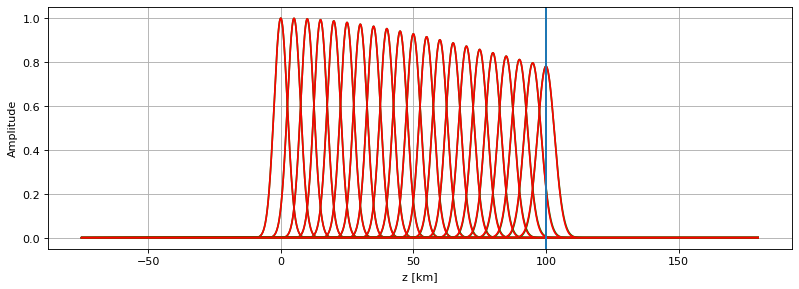

In [6]:
h_plus =  (1/sqrt(1+(z*beta2/T0**2)**2)) * exp(-(m*T+beta2* Omega* z)**2/(2*T0**2*(1+(z**2*beta2**2)/(T0**4)))) 
first = diff(h_plus, z).subs(z, -m*T/(beta2*Omega))
second = diff(diff(h_plus, z), z).subs(z, -m*T/(beta2*Omega))
second.subs(T, T0)
#display(h_plus)
h_simp = (1/sqrt(1+(-m*T/(Omega * T0**2))**2)) * exp(-(m*T+beta2* Omega* z)**2/(2*T0**2*(1+(-m*T/(Omega * T0**2))**2))) 
#display(h_simp)
instance = h_plus.subs(params)
instance_approx = h_simp.subs(params)

zm = -1 * params[T]/(params[beta2] * params[Omega])
print("Inter-collision spacing: ", zm/1e3, "km")
h = lambdify((z, m), instance, "numpy")
h_approx = lambdify((z, m), instance_approx, "numpy")
print(-params[T0]**2/params[beta2] / 1e3 , " km")

counter = 0
window_steps = 1
N_collisions = int(np.ceil(solution.root))
decimation = 1

guard = 75000
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), dpi=80)
p=ax
start_collision = counter * window_steps

first_zm = - start_collision * params[T] / (params[beta2] * params[Omega]) 
last_zm = - (N_collisions * decimation + start_collision) * params[T] / (params[beta2] * params[Omega])
space = (np.array(range(0, 10000)) * (last_zm - first_zm + 2*guard)/10000) + (first_zm - guard) # sum guards before and afters

print("From ", space[0]/1000, "km", "to ", space[-1]/1000, "km :")
print("\tCollisions number :", *[k*decimation + start_collision for k in range(N_collisions)], "\n")

for k in [k*decimation + start_collision for k in range(N_collisions)]:
    p.plot(space/1e3, h(space, k), color="green")
    p.plot(space/1e3, h_approx(space, k), color="red")
    p.set_xlabel("z [km]")
    p.set_ylabel("Amplitude")
    #p.set_title("From " + str(first_zm/zm) + "zm to " + str(last_zm/zm) + "zm :")
    p.grid()
    p.axvline(x = L/1e3)
counter+=1